In [51]:
################################################
########## COUNTING WORDS AND PHRASES ##########
################################################

In [52]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [53]:
# read in overall dataframe
movie_df = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df.csv") 

In [54]:
# read in dataframes separated by year
movie_df_1940_2020 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1940_2020.csv") 
movie_df_1940_1960 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1940_1960.csv")
movie_df_1960_1980 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1960_1980.csv")
movie_df_1980_2000 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1980_2000.csv")
movie_df_2000_2020 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_2000_2020.csv")

KeyboardInterrupt: 

In [ ]:
# read in genre dataframe
movieGenre = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_genre.csv") 

In [ ]:
# double check dataframe
movie_df_1940_2020.head()

In [ ]:
##############################
########## WORD2VEC ##########
##############################

In [ ]:
movie_df_1940_2020['tokenized_sents'] = movie_df_1940_2020['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df_1940_2020['normalized_sents'] = movie_df_1940_2020['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
# To load our data our data we give all the sentences to the trainer:
movieW2V_1940_2020 = gensim.models.word2vec.Word2Vec(movie_df_1940_2020['normalized_sents'].sum())

In [ ]:
movieW2V_1940_2020.wv.index2entity[:10]

In [ ]:
movie_df_1940_1960['tokenized_sents'] = movie_df_1940_1960['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df_1940_1960['normalized_sents'] = movie_df_1940_1960['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
# To load our data our data we give all the sentences to the trainer:
movieW2V_1940_1960 = gensim.models.word2vec.Word2Vec(movie_df_1940_1960['normalized_sents'].sum())

In [ ]:
movieW2V_1940_1960.wv.index2entity[:10]

In [ ]:
print(movieW2V_1940_1960)

In [ ]:
# Can look at a few things that come from the word vectors. 
# The first is to find similar vectors (cosine similarity):
movieW2V_1940_1960.most_similar('right')

In [ ]:
# Find which word least matches the others within a word set (cosine similarity):
# the fact that 'thank' matches least goes with themes of non-collaborative
movieW2V_1940_1960.doesnt_match(['good', 'love', 'want', 'thank'])

In [ ]:
# save the vectors for later use:
movieW2V_1940_1960.save("movieWORD2Vec_1940_1960")

In [ ]:
# use dimension reduction to visulize the vectors. 
# start by selecting a subset we want to plot. 
# look at the top words from the set:
numWords_1940_1960 = 10
targetWords_1940_1960 = movieW2V_1940_1960.wv.index2word[:numWords_1940_1960]

In [ ]:
# extract their vectors and create our own smaller matrix that preserved the distances from the original:
wordsSubMatrix_1940_1960 = []
for word in targetWords_1940_1960:
    wordsSubMatrix_1940_1960.append(movieW2V_1940_1960[word])
wordsSubMatrix_1940_1960 = np.array(wordsSubMatrix_1940_1960)
wordsSubMatrix_1940_1960

In [ ]:
# use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize
pcaWords_1940_1960 = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix_1940_1960)
reducedPCA_data_1940_1960 = pcaWords_1940_1960.transform(wordsSubMatrix_1940_1960)
#T-SNE is theoretically better, but you should experiment
tsneWords_1940_1960 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_1940_1960)

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_1940_1960[:, 0], tsneWords_1940_1960[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_1940_1960):
    ax.annotate(word, (tsneWords_1940_1960[:, 0][i],tsneWords_1940_1960[:, 1][i]), size =  20 * (numWords_1940_1960 - i) / numWords_1940_1960)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
#############################
########## DOC2VEC ##########
#############################

In [ ]:
# We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.
keywords = ['good', 'bad', 'kill', 'save', 'stop', 'fight','beat','man','woman','miss','mr','mother','dad','good','right','wrong']

In [ ]:
taggedDocs_1940_1960 = []
for index, row in movie_df_1940_1960.iterrows():
    #Just doing a simple keyword assignment
    docKeywords_1940_1960 = [s for s in keywords if s in row['normalized_words']]
    docKeywords_1940_1960.append(row['Year'])
    docKeywords_1940_1960.append(row['Movie Name']) #This lets us extract individual documnets since doi's are unique
    taggedDocs_1940_1960.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords_1940_1960))
movie_df_1940_1960['TaggedAbstracts'] = taggedDocs_1940_1960

In [ ]:
# Now we can train a Doc2Vec model:
movieD2V_1940_1960 = gensim.models.doc2vec.Doc2Vec(movie_df_1940_1960['TaggedAbstracts'], size = 50) #Limiting to 50 dimensions

In [ ]:
# In the doc2vec model, the documents have vectors just as the words do, 
# so that we can compare documents with each other and also with words 
# First, we will calculate the distance between a word and documents in the dataset:
movieD2V_1940_1960.docvecs.most_similar([ movieD2V_1940_1960['kill'] ], topn=5 )

In [ ]:
################################
########## PROJECTION ##########
################################

In [ ]:
#words to create dimensions
tnytTargetWords = ['good','bad','fight', 'kill', 'save', 'stop']
#words we will be mapping
tnytTargetWords += ["man","woman","old","money","right", "know","come"]

In [ ]:
wordsSubMatrix_1940_1960 = []
for word in tnytTargetWords:
    wordsSubMatrix_1940_1960.append(movieW2V_1940_1960[word])
wordsSubMatrix_1940_1960 = np.array(wordsSubMatrix_1940_1960)

In [ ]:
pcaWordsMovie_1940_1960 = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix_1940_1960)
reducedPCA_dataMovie_1940_1960 = pcaWords_1940_1960.transform(wordsSubMatrix_1940_1960)
#T-SNE is theoretically better, but you should experiment
tsneWordsMovie_1940_1960 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataMovie_1940_1960)

In [ ]:
# we see that good and bad are strongly represented, but that fight and kill are 
## also highly represented -- showing a strong theme of violence, with a nod to 'stop' as well
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsMovie_1940_1960[:, 0], tsneWordsMovie_1940_1960[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsMovie_1940_1960[:, 0][i],tsneWordsMovie_1940_1960[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Define some convenient functions for getting dimensions.
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [ ]:
# Let's calculate 2 dimensions: violence and nonviolence
violence_1940_1960 = dimension(movieW2V_1940_1960, ['bad'], ['fight','kill'])
nonviolence_1940_1960 = dimension(movieW2V_1940_1960, ['good'], ['save','stop'])

In [55]:
# words around gender and incentives
gender = ["man","woman"]
incentive = ["money","know","right"]

In [56]:
# Define a function to project words in a word list to each of the 2 dimensions
def makeDF(model, word_list):
    n = []
    v = []
    for word in word_list:
        n.append(sklearn.metrics.pairwise.cosine_similarity(movieW2V_1940_1960[word].reshape(1,-1), violence_1940_1960.reshape(1,-1))[0][0])
        v.append(sklearn.metrics.pairwise.cosine_similarity(movieW2V_1940_1960[word].reshape(1,-1), nonviolence_1940_1960.reshape(1,-1))[0][0])
    df = pd.DataFrame({'nonviolence': n, 'violence': v}, index = word_list)
    return df

In [57]:
# Get the projections.
genderdf_1940_1960 = makeDF(movieW2V_1940_1960, gender) 
incentivedf_1940_1960 = makeDF(movieW2V_1940_1960, incentive)

In [58]:
# Define some useful functions for plotting.
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

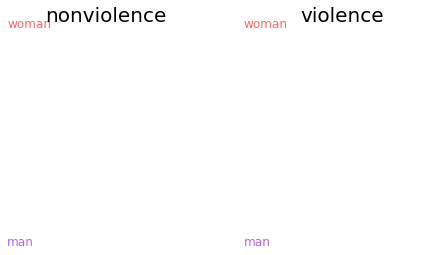

In [59]:
# Plot the gender words in the 2 dimensions
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, genderdf_1940_1960, 'nonviolence')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, genderdf_1940_1960, 'violence')
plt.show()

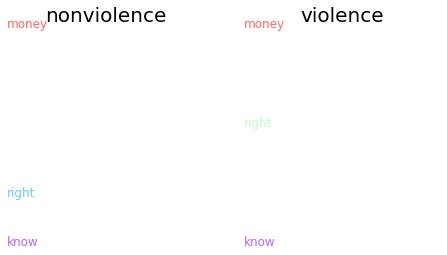

In [60]:
# Plot the incentive words in the dimensions 
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, incentivedf_1940_1960, 'nonviolence')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, incentivedf_1940_1960, 'violence')
plt.show()

In [61]:
###############################################
########## LINGUISTIC CHANGE OR DIFF ##########
###############################################

In [62]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [63]:
# create two collections of embeddings, one the original and one the aligned
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [64]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum(), min_count=1)
    return embeddings_raw

In [65]:
# generate the models:
rawEmbeddings, comparedEmbeddings = compareModels(movie_df_1940_2020, 'Year')

NameError: name 'copy' is not defined

In [ ]:
rawEmbeddings.keys()

In [ ]:
# compare across all permutions so we will define another function to help
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [ ]:
# look at some test words
## see that the usage of 'right' has stabilized from 1995-now; reason? interesting overlap with digital age
## would require more probing
## it seems to have undergone a lot of fluctuations, potentially pointing to controversy over its meaning
targetWord = 'right'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
# the usage of 'nice' has also stabilized since 1995
## it seems to have undergone a lot of fluctuations, potentially pointing to controversy over its meaning
targetWord = 'nice'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)
wordDivergences

In [ ]:
# look at the most divergent word 'yes'
## note again the 1995 trend
## there are certain years that are diff from others -- ~1953,1979,1990
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
# 'well' is the least divergent word
## it also follws the 1995 trend, but has generally been much more stable over time
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()